In [15]:
import numpy as np
import pandas as pd
# import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

# import lightgbm as lgb

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

from utils import *
from aux_functions import *

In [2]:
data_folder =  'csv_data/'
suffix = ''

df_public = pd.read_csv(data_folder + 'df_public_test' + suffix +'.csv', index_col='Unnamed: 0')
df_private = pd.read_csv(data_folder + 'df_private_test' + suffix +'.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv(data_folder + 'df_ER' + suffix +'.csv', index_col='Unnamed: 0')
df_NR = pd.read_csv(data_folder + 'df_NR' + suffix +'.csv', index_col='Unnamed: 0')

df_NR['abs_dmu_x'] = np.abs(df_NR['mu_x'] - 288)
df_NR['abs_dmu_y'] = np.abs(df_NR['mu_y'] - 288)

df_ER['abs_dmu_x'] = np.abs(df_ER['mu_x'] - 288)
df_ER['abs_dmu_y'] = np.abs(df_ER['mu_y'] - 288)

df_public['abs_dmu_x'] = np.abs(df_public['mu_x'] - 288)
df_public['abs_dmu_y'] = np.abs(df_public['mu_y'] - 288)

df_private['abs_dmu_x'] = np.abs(df_private['mu_x'] - 288)
df_private['abs_dmu_y'] = np.abs(df_private['mu_y'] - 288)

df = pd.concat([df_NR, df_ER])

# feat_list = [df_ER.columns[i] for i in range(len(df_ER.columns)) if df_ER.columns[i][-11:-1] != 'bkgr_only_']
# feat_list_bkgr = [df_ER.columns[i] for i in range(len(df_ER.columns)) if df_ER.columns[i][-11:-1] == 'bkgr_only_']

In [3]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#               'dfr', 
#               'dmu', 'dsigma', 
#               'sigma_x', 'sigma_y', 
#               'mu_x', 'mu_y',
              'abs_dmu_x', 'abs_dmu_y',
#                 'abs_sum_dmu'
#               'n_excess_bins_x', 'n_excess_bins_y', 
              ]

MID_clf_vars = ['sigma_y']
LOW_clf_vars = ['sigma_y']

## Improved solution:

In [4]:
# X_ER = df.query('sig_count_y > 100 and event_energy>1 and event_energy<20 and event_class == "ER"').sig_count_y.values.reshape(-1, 1).ravel()
# y_ER = df.query('sig_count_y > 100 and event_energy>1 and event_energy<20 and event_class == "ER"').event_energy.values.reshape(-1, 1).ravel()
# a_ER, b_ER = np.polyfit(y_ER, X_ER, deg=1)

# X_NR = df.query('event_energy>3 and event_energy<30 and event_class == "NR"').sig_count_y.values.reshape(-1, 1).ravel()
# y_NR = df.query('event_energy>3 and event_energy<30 and event_class == "NR"').event_energy.values.reshape(-1, 1).ravel()
# a_NR, b_NR = np.polyfit(y_NR, X_NR, deg=1)

a, b = fit_line(df)

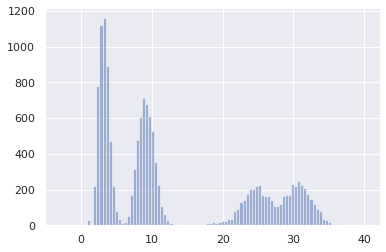

In [5]:
E_pred = invert_regr(a, b, df_private['sig_count_y'].values)
hist = plt.hist(E_pred, bins=100, range=(-3, 40), alpha=0.5, label='NR')
# hist_ER = plt.hist(E_pred_ER, bins=100, range=(-3, 15), alpha=0.5, label='ER')
# plt.legend()
plt.show()

In [6]:
# [-inf, 6] [6, 14] [14, +inf]

In [7]:
# Labels: ER->1 NR->0

## High energies

In [8]:
# df_NR[feat_list].columns

In [9]:
# df_1 = df[df['event_energy'] == 1][:500]
# df_3 = df[df['event_energy'] == 3][:500]
# df_6 = df[df['event_energy'] == 6][:500]
# df_10 = df[df['event_energy'] == 10][:500]
# df_20 = df[df['event_energy'] == 20][:500]
# df_20 = df_20.query('event_class != "ER"')
# df_30 = df[df['event_energy'] == 30]
# df_30 = df_30.query('event_class != "NR"')
# df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])

df_20 = df[df['event_energy'] == 20]
df_20 = df_20.query('event_class != "ER"')
df_30 = df[df['event_energy'] == 30]
df_30 = df_30.query('event_class != "NR"')
df_w_vs_all = pd.concat([df_20,df_30])

X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30

In [10]:
lgb_train = lgb.Dataset(X, y, free_raw_data=False)
lgb_eval = lgb.Dataset(X, y, reference=lgb_train)

HE_clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

# HE_clf = tree.DecisionTreeClassifier(max_depth=2).fit(X.values, y)

Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.598701
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.521372
[3]	valid_0's binary_logloss: 0.456511
[4]	valid_0's binary_logloss: 0.401695
[5]	valid_0's binary_logloss: 0.354887
[6]	valid_0's binary_logloss: 0.314776
[7]	valid_0's binary_logloss: 0.27999
[8]	valid_0's binary_logloss: 0.249393
[9]	valid_0's binary_logloss: 0.222585
[10]	valid_0's binary_logloss: 0.199078
[11]	valid_0's binary_logloss: 0.178256
[12]	valid_0's binary_logloss: 0.159822
[13]	valid_0's binary_logloss: 0.143467
[14]	valid_0's binary_logloss: 0.128919
[15]	valid_0's binary_logloss: 0.115959
[16]	valid_0's binary_logloss: 0.104464
[17]	valid_0's binary_logloss: 0.0941166
[18]	valid_0's binary_logloss: 0.084918
[19]	valid_0's binary_logloss: 0.0766048
[20]	valid_0's binary_logloss: 0.0691496
[21]	valid_0's binary_logloss: 0.0624295
[22]	valid_0's binary_logloss: 0.0564012
[23]	valid_0's binary_logloss: 0.0509771
[24]	valid_0's binary_l

In [11]:
HE_clf.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars])

array([0.99999999, 0.99999997])

In [12]:
HE_clf.predict(df.query('event_energy == 30 and event_class == "NR"')[wiggly_vars])

array([1.37109072e-08, 1.36715695e-07])

#### public

In [13]:
E_pred_public = invert_regr(a, b, df_public['sig_count_y'].values)
idx_HE_public = [i for i in range(len(E_pred_public)) if E_pred_public[i] >= 14]

In [14]:
HE_cl_pred_public = np.array(list(HE_clf.predict(df_public.iloc[idx_HE_public][wiggly_vars])))
HE_reg_pred_public = np.array([30 if HE_cl_pred_public[i]>0.5 else 20 for i in range(len(idx_HE_public))])
HE_im_names_public = np.array(list(df_public.iloc[idx_HE_public]['image_name'].values))

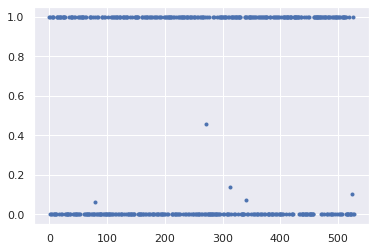

In [15]:
plt.plot(HE_cl_pred_public, '.')

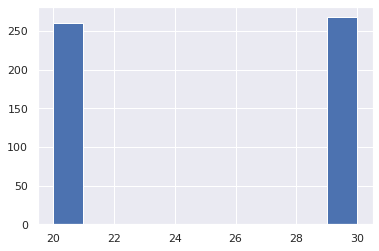

In [16]:
plt.hist(HE_reg_pred_public)
plt.show()

In [18]:
# publ_cl_pred = gbm.predict(df_public[wiggly_vars])
# E_pred_w = (df_public[publ_cl_pred > 0.5].sig_count_y.values - b_NR)/a_NR
# E_pred_nw = (df_public[publ_cl_pred <= 0.5].sig_count_y.values - b_NR)/a_NR

In [19]:
# plt.hist((df.query('event_energy==30 and event_class=="ER"')['sig_count_y'] - b_NR)/a_NR, range=(0,50), bins=100)

In [20]:
# fig, axs = plt.subplots(1, 2, figsize=(20,8))
# axs[0].hist(E_pred_nw, bins=100, range=(-3, 50), alpha=0.5)
# axs[0].hist(E_pred_w, bins=100, range=(-3, 50), alpha=0.5)
# axs[0].set_xlabel('E_regr')
# axs[1].hist(E_pred_nw, bins=100, range=(-3, 15), alpha=0.5)
# axs[1].hist(E_pred_w, bins=100, range=(-3, 15), alpha=0.5)
# axs[0].set_xlabel('E_regr')
# plt.show()

#### private

In [17]:
E_pred_private = invert_regr(a, b, df_private['sig_count_y'].values)
idx_HE_private = [i for i in range(len(E_pred_private)) if E_pred_private[i] >= 14]

In [18]:
HE_cl_pred = np.array(list(HE_clf.predict(df_private.iloc[idx_HE_private][wiggly_vars])))
HE_reg_pred = np.array([20 if HE_cl_pred[i]>0.5 else 30 for i in range(len(idx_HE_private))])
HE_im_names = np.array(list(df_private.iloc[idx_HE_private]['image_name'].values))

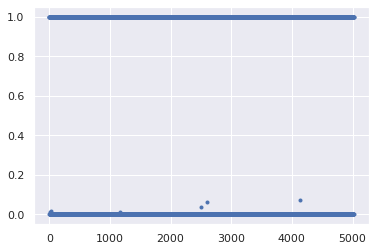

In [19]:
plt.plot(HE_cl_pred, '.')
plt.show()

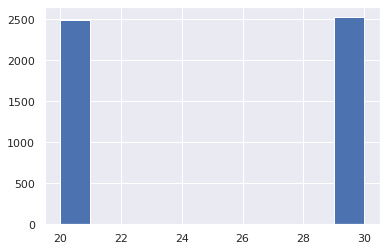

In [20]:
p = plt.hist(HE_reg_pred)
plt.show()

In [21]:
p

(array([2493.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2527.]),
 array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.]),
 <BarContainer object of 10 artists>)

In [22]:
priv_cl_pred = HE_clf.predict(df_private[wiggly_vars])
E_priv_w = (df_private[priv_cl_pred > 0.5].sig_count_y.values - b)/a
E_priv_nw = (df_private[priv_cl_pred <= 0.5].sig_count_y.values - b)/a

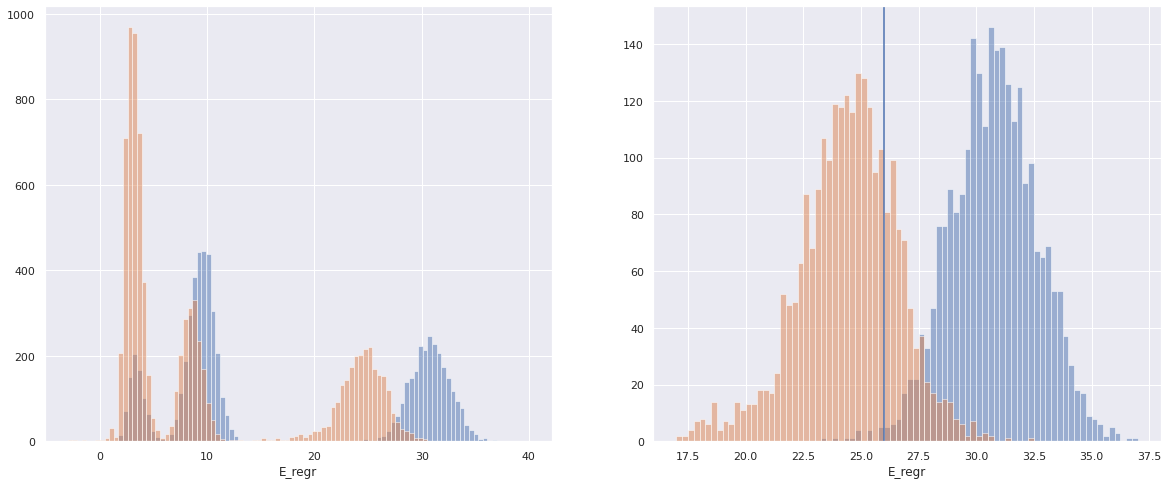

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_priv_nw, bins=100, range=(-3, 40), alpha=0.5)
axs[0].hist(E_priv_w, bins=100, range=(-3, 40), alpha=0.5)
axs[0].set_xlabel('E_regr')
axs[1].hist(E_priv_nw, bins=80, range=(17, 37), alpha=0.5)
axs[1].hist(E_priv_w, bins=80, range=(17, 37), alpha=0.5)
axs[1].set_xlabel('E_regr')
axs[1].axvline(26)
plt.show()

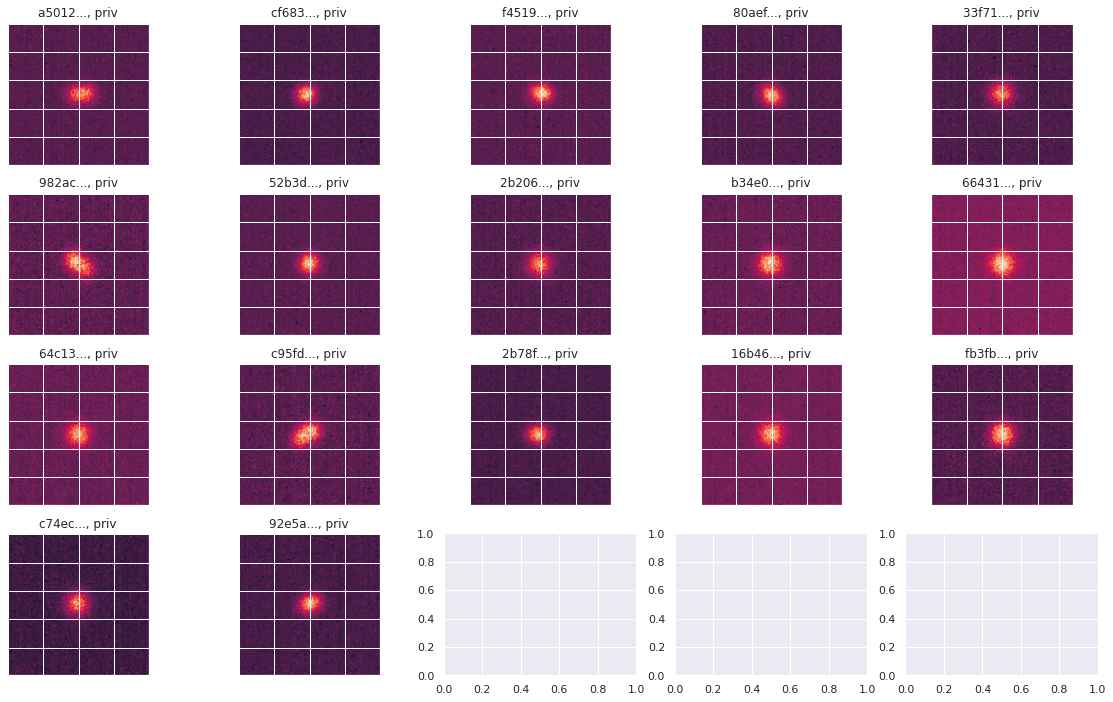

In [297]:
v1 = [i for i in range(len(priv_cl_pred)) if (priv_cl_pred[i] < 0.5) and (df_private.iloc[i].sig_count_y - b_NR)/a_NR > 17.5 and (df_private.iloc[i].sig_count_y - b_NR)/a_NR < 26]
s = list(df_private['image_name'].iloc[v1].values)
t = plot_images('../../idao_dataset/', im_filename=s, max_num_images=30, rand_seed=None)

In [18]:
v1 = [i for i in range(len(priv_cl_pred)) if (priv_cl_pred[i] > 0.5) and (df_private.iloc[i].sig_count_y - b_NR)/a_NR < 1.5 and (df_private.iloc[i].sig_count_x - b_NR)/a_NR > 9]
s = list(df_private['image_name'].iloc[v1].values)
t = plot_images('../../idao_dataset/', im_filename=s, max_num_images=10, rand_seed=None)

NameError: name 'priv_cl_pred' is not defined

In [299]:
len(v1)

45

#### submission

In [301]:
# cl_pred = np.append(np.round(HE_cl_pred_public), np.round(HE_cl_pred))
# reg_pred = np.append(HE_reg_pred_public, HE_reg_pred)
# im_names = np.append(HE_im_names_public, HE_im_names)
# #generate_submission(cl_pred, reg_pred, im_names, 'HE_predictions')

In [303]:
# tmp = plot_images('../../idao_dataset/', im_filename='HE_predictions.csv', max_num_images=30)

## Mid energies

In [24]:
# MID_clf_vars = [
# #               'chi2_pvalue_x', 'chi2_pvalue_y', 
# #                'chi2_x', 'chi2_y',
# #               'dfr', 
# #               'dmu', 'dsigma', 
# #               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
#               'sigma_x', 'sigma_y', 
# #               'sigma_error_x', 'sigma_error_y', 
# #               'mu_x', 'mu_y', 
# #               'mu_error_x', 'mu_error_y', 
# #               'n_excess_bins_x', 'n_excess_bins_y', 
# #                'nfcn_total_x', 'nfcn_total_y',
# #        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
# #               'sig_count_x', 'sig_count_y', 
# #               'sig_density_x', 'sig_density_y', 
# #                'dsig_count'
#               ]

In [25]:
# df_6 = df[df['event_energy'] == 6]
# df_6 = df_6.query('event_class != "ER"')
# df_10 = df[df['event_energy'] == 10]
# df_10 = df_10.query('event_class != "NR"')
# df_6_vs_10 = pd.concat([df_6, df_10])

In [26]:
# X = df_6_vs_10[MID_clf_vars]
# y = df_6_vs_10['event_energy'] == 10

In [27]:
# lgb_train = lgb.Dataset(X, y, free_raw_data=False)
# lgb_eval = lgb.Dataset(X, y, reference=lgb_train)

In [28]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'max_depth': 4,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': -1,
#     'early_stopping_rounds': 10
# }

In [29]:
# MID_clf = lgb.train(
#                 params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=lgb_eval,  # eval training data
#                 verbose_eval=True,
# #                 feature_name=X_train.columns,
# #                 categorical_feature=[21]
#                )

In [30]:
# df_temp = pd.DataFrame(columns=['sigma_y'])
# df_temp.sigma_y = [5.25, 1, -100, -1, 5.5, 10, 20]
# MID_clf = Sigma_classifier()
# MID_clf.predict(df_temp[MID_clf_vars])

In [31]:
MID_clf = Sigma_classifier()

In [32]:
MID_clf.predict(df.query('event_energy == 6 and event_class == "ER"')[MID_clf_vars])

[0.5736627428329505]

In [33]:
MID_clf.predict(df.query('event_energy == 10 and event_class == "NR"')[MID_clf_vars])

[0.40333655461645157, 0.47694434648894934]

#### public

In [34]:
E_pred_public = invert_regr(a, b, df_public['sig_count_y'].values)
idx_MID_public = [i for i in range(len(E_pred_public)) if E_pred_public[i] > 6 and E_pred_public[i] < 14]

In [35]:
MID_cl_pred_public = np.array(list(MID_clf.predict(df_public.iloc[idx_MID_public][MID_clf_vars])))
MID_reg_pred_public = np.array([10 if MID_cl_pred_public[i]>0.5 else 6 for i in range(len(idx_MID_public))])
MID_im_names_public = np.array(list(df_public.iloc[idx_MID_public]['image_name'].values))

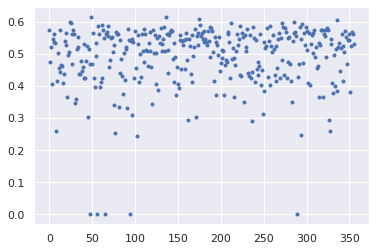

In [36]:
plt.plot(MID_cl_pred_public, '.')

(array([146.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 210.]),
 array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 10 artists>)

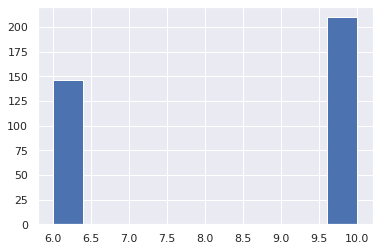

In [37]:
plt.hist(MID_reg_pred_public)

#### private

In [38]:
E_pred_private = invert_regr(a, b, df_private['sig_count_y'].values)
idx_MID_private = [i for i in range(len(E_pred_private)) if E_pred_private[i] > 6 and E_pred_private[i] < 14]

In [39]:
MID_cl_pred = np.array(list(MID_clf.predict(df_private.iloc[idx_MID_private][MID_clf_vars])))
MID_reg_pred = np.array([6 if MID_cl_pred[i]>0.5 else 10 for i in range(len(idx_MID_private))])
MID_im_names = np.array(list(df_private.iloc[idx_MID_private]['image_name'].values))

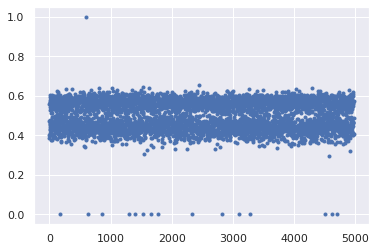

In [40]:
plt.plot(MID_cl_pred, '.')

(array([2485.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2487.]),
 array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 10 artists>)

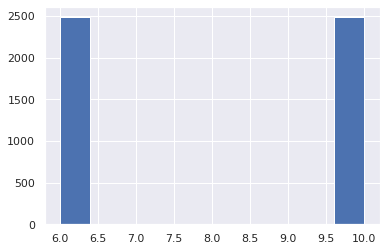

In [41]:
plt.hist(MID_reg_pred)

In [47]:
cl_pred = np.append(np.round(MID_cl_pred_public), np.round(MID_cl_pred))
reg_pred = np.append(MID_reg_pred_public, MID_reg_pred)
im_names = np.append(MID_im_names_public, MID_im_names)
# generate_submission(cl_pred, reg_pred, im_names, 'MID_predictions')

In [48]:
# tmp = plot_images('../../idao_dataset/', im_filename='MID_predictions.csv', max_num_images=30)

## Low energies

In [49]:
# df_1 = df[df['event_energy'] == 1]
# df_1 = df_1.query('event_class != "ER"')
# df_3 = df[df['event_energy'] == 3]
# df_3 = df_3.query('event_class != "NR"')
# df_1_vs_3 = pd.concat([df_1, df_3])

In [50]:
# clf_vars = [ 
#             'sig_count_y'
#               ]

In [51]:
# X = df_1_vs_3[clf_vars]
# y = df_1_vs_3['event_energy'] == 3

#### public

In [52]:
# clf_vars_publ = [
# #             'chi2_pvalue_bkgr_only_x',
# #              'chi2_pvalue_bkgr_only_y',
# #             'sigma_x', 'sigma_y'
#     'sig_count_x', 'sig_count_y'
#               ]



In [53]:
# df_1 = df[df['event_energy'] == 1]
# df_1 = df_1.query('event_class != "ER"')
# df_3 = df[df['event_energy'] == 3]
# df_3 = df_3.query('event_class != "NR"')
# df_1_vs_3 = pd.concat([df_1, df_3])

In [54]:
# X = df_1_vs_3[clf_vars_publ]
# y = df_1_vs_3['event_energy'] == 3

In [55]:
# lgb_train = lgb.Dataset(X, y, free_raw_data=False)
# lgb_eval = lgb.Dataset(X, y, reference=lgb_train)

In [56]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'max_depth': 4,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': -1,
#     'early_stopping_rounds': 10
# }

In [57]:
# clf = lgb.train(
#                 params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=lgb_eval,  # eval training data
#                 verbose_eval=True,
# #                 feature_name=X_train.columns,
# #                 categorical_feature=[21]
#                )

In [210]:
LOW_clf = Sigma_classifier(sigma_y_th=5.25)

In [211]:
LOW_clf.predict(df.query('event_energy == 1 and event_class == "ER"')[LOW_clf_vars])

[0.6662561911943932, 0.0, 0.8270720783593146]

In [185]:
LOW_clf.predict(df.query('event_energy == 3 and event_class == "NR"')[LOW_clf_vars])

[0.22770937218962195, 0.4063753223558354]

In [186]:
E_pred_public = invert_regr(a, b, df_public['sig_count_y'].values)
idx_LOW_public = [i for i in range(len(E_pred_public)) if E_pred_public[i] <= 6]

In [187]:
LOW_cl_pred_public = np.array(list(LOW_clf.predict(df_public.iloc[idx_LOW_public][LOW_clf_vars])))
LOW_reg_pred_public = np.array([3 if LOW_cl_pred_public[i]>0.5 else 1 for i in range(len(idx_LOW_public))])
LOW_im_names_public = np.array(list(df_public.iloc[idx_LOW_public]['image_name'].values))

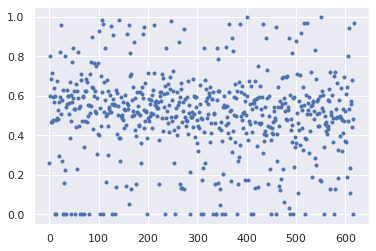

In [188]:
plt.plot(LOW_cl_pred_public, '.')

(array([271.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 347.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

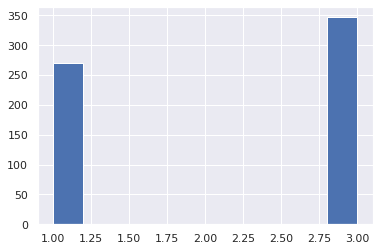

In [189]:
plt.hist(LOW_reg_pred_public)

#### private

In [190]:
E_pred_private = invert_regr(a, b, df_private['sig_count_y'].values)
idx_LOW_private = [i for i in range(len(E_pred_private)) if E_pred_private[i] <= 6]

In [191]:
LOW_cl_pred = np.array(list(LOW_clf.predict(df_private.iloc[idx_LOW_private][LOW_clf_vars])))
LOW_reg_pred = np.array([1 if LOW_cl_pred[i]>0.5 else 3 for i in range(len(idx_LOW_private))])
LOW_im_names = np.array(list(df_private.iloc[idx_LOW_private]['image_name'].values))

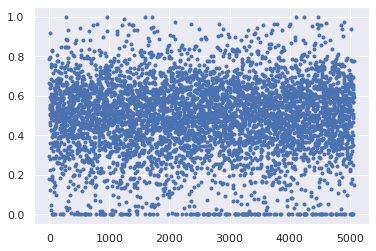

In [192]:
plt.plot(LOW_cl_pred, '.')

(array([2512.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2554.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

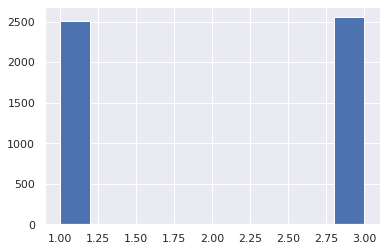

In [193]:
plt.hist(LOW_reg_pred)

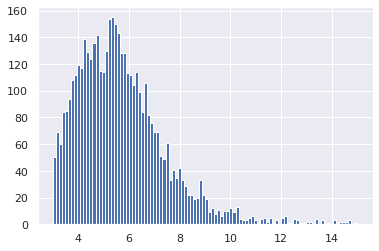

In [194]:
plt.hist((df_private.iloc[idx_LOW_private]['sigma_y'].values), bins=100, range=(3,15))
plt.show()

In [195]:
# priv_cl_pred = np.array(LOW_clf.predict(df_private[LOW_clf_vars]))
# E_priv_w = (df_private[priv_cl_pred > 0.5].sig_count_y.values - b)/a
# E_priv_nw = (df_private[priv_cl_pred <= 0.5].sig_count_y.values - b)/a

# fig, axs = plt.subplots(1, 2, figsize=(20,8))
# axs[0].hist(E_priv_nw, bins=100, range=(-3, 40), alpha=0.5)
# axs[0].hist(E_priv_w, bins=100, range=(-3, 40), alpha=0.5)
# axs[0].set_xlabel('E_regr')
# axs[1].hist(E_priv_nw, bins=80, range=(1, 3), alpha=0.5)
# axs[1].hist(E_priv_w, bins=80, range=(1, 3), alpha=0.5)
# axs[1].set_xlabel('E_regr')
# axs[1].axvline(26)
# plt.show()

In [196]:
# LOW_cl_pred = np.array(list((df_private.iloc[idx_LOW_private][clf_vars].values - E_th) / 1000))
# LOW_cl_pred[LOW_cl_pred > 1] = 1
# LOW_cl_pred[LOW_cl_pred < -1] = -1
# LOW_cl_pred += 1
# LOW_cl_pred /= 2
# LOW_cl_pred = 1 - LOW_cl_pred

# LOW_reg_pred = np.array([1 if LOW_cl_pred[i]>0.5 else 3 for i in range(len(idx_LOW_private))])
# LOW_im_names = np.array(list(df_private.iloc[idx_LOW_private]['image_name'].values))

In [197]:
# val_pred = np.array((df.query('event_energy == 1 and event_class == "ER"')['sig_count_y'].values - E_th)/1000)
# val_pred[val_pred>1] = 1
# val_pred[val_pred < -1] = -1
# val_pred += 1
# val_pred /= 2
# val_pred = 1 - val_pred
# print(df.query('event_energy == 1 and event_class == "ER"')['sig_count_y'])
# print(val_pred)

In [198]:
# val_pred = np.array((df.query('event_energy == 3 and event_class == "NR"')['sig_count_y'].values - E_th)/1000)
# val_pred[val_pred>1] = 1
# val_pred[val_pred < -1] = -1
# val_pred += 1
# val_pred /= 2
# val_pred = 1 - val_pred
# print(df.query('event_energy == 3 and event_class == "NR"')['sig_count_y'])
# print(val_pred)

### Final adjustments

In [199]:
priv_cl_pred = HE_clf.predict(df_private[wiggly_vars])

In [200]:
# left tail 

In [201]:
v1 = [i for i in range(len(priv_cl_pred)) if (priv_cl_pred[i] > 0.5) and (df_private.iloc[i].sig_count_y - b)/a < 1.5 and (df_private.iloc[i].sig_count_x - b)/a > 9]
s = list(df_private['image_name'].iloc[v1].values)
# t = plot_images('../../idao_dataset/', im_filename=s, max_num_images=100, rand_seed=None)
incor_idx = [np.argwhere(LOW_im_names == s[i]).ravel()[0] for i in range(len(s))]
LOW_reg_pred[incor_idx] = 20
LOW_cl_pred[incor_idx] = 1

In [202]:
# right tail

In [203]:
v1 = [i for i in range(len(df_private)) if (df_private.iloc[i].sig_count_y - b)/a > 35 and (df_private.iloc[i].sig_count_x - b)/a < 20]
s = list(df_private['image_name'].iloc[v1].values)
incor_idx = [np.argwhere(HE_im_names == s[i]).ravel()[0] for i in range(len(s))]
HE_reg_pred[incor_idx] = 1
# t = plot_images('../../idao_dataset/', im_filename=s, max_num_images=37, rand_seed=None)

In [204]:
# intersection of NR and ER at high energies

In [205]:
v1 = [i for i in range(len(priv_cl_pred)) if (priv_cl_pred[i] < 0.5) and (df_private.iloc[i].sig_count_y - b)/a > 14 and (df_private.iloc[i].sig_count_y - b)/a < 26]
s = list(df_private['image_name'].iloc[v1].values)
s = [s[0], s[5], s[11]]
incor_idx = [np.argwhere(HE_im_names == s[i]).ravel()[0] for i in range(len(s))]
HE_reg_pred[incor_idx] = 20
HE_cl_pred[incor_idx] = 1
# t = plot_images('../../idao_dataset/', im_filename=s, max_num_images=50, rand_seed=None)

In [206]:
# private distribution

In [17]:
cl_pred = np.append(np.round(LOW_cl_pred), np.round(MID_cl_pred))
cl_pred = np.append(cl_pred, np.round(HE_cl_pred))

reg_pred = np.append(LOW_reg_pred, MID_reg_pred)
reg_pred = np.append(reg_pred, HE_reg_pred)

im_names = np.append(LOW_im_names, MID_im_names)
im_names = np.append(im_names, HE_im_names)

NameError: name 'LOW_cl_pred' is not defined

(array([7525.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7533.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

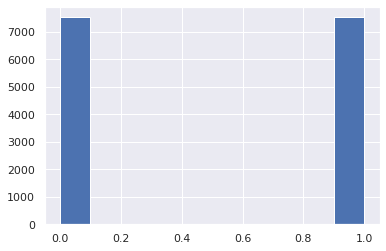

In [208]:
plt.hist(cl_pred)

(array([2517., 2514., 2485.,    0., 2487.,    0.,    0.,    0.,    0.,
        2531.,    0.,    0.,    0.,    0., 2524.]),
 array([ 1.        ,  2.93333333,  4.86666667,  6.8       ,  8.73333333,
        10.66666667, 12.6       , 14.53333333, 16.46666667, 18.4       ,
        20.33333333, 22.26666667, 24.2       , 26.13333333, 28.06666667,
        30.        ]),
 <BarContainer object of 15 artists>)

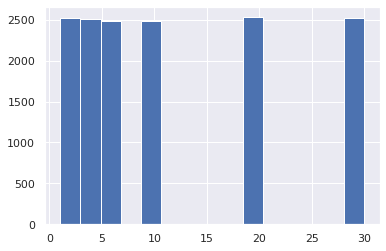

In [209]:
plt.hist(reg_pred, bins=15)

## Full submission

In [212]:
cl_pred = np.append(np.round(LOW_cl_pred_public), np.round(LOW_cl_pred))
cl_pred = np.append(cl_pred, np.round(MID_cl_pred_public))
cl_pred = np.append(cl_pred, np.round(MID_cl_pred))
cl_pred = np.append(cl_pred, np.round(HE_cl_pred_public))
cl_pred = np.append(cl_pred, np.round(HE_cl_pred))

reg_pred = np.append(LOW_reg_pred_public, LOW_reg_pred)
reg_pred = np.append(reg_pred, MID_reg_pred_public)
reg_pred = np.append(reg_pred, MID_reg_pred)
reg_pred = np.append(reg_pred, HE_reg_pred_public)
reg_pred = np.append(reg_pred, HE_reg_pred)

im_names = np.append(LOW_im_names_public, LOW_im_names)
im_names = np.append(im_names, MID_im_names_public)
im_names = np.append(im_names, MID_im_names)
im_names = np.append(im_names, HE_im_names_public)
im_names = np.append(im_names, HE_im_names)

assert(len(im_names) == len(reg_pred))
assert(len(im_names) == len(cl_pred))
assert(len(im_names) == len(df_private) + len(df_public))

generate_submission(cl_pred, reg_pred, im_names, 'pipeline_prediction_draft')

(array([8237.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8323.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

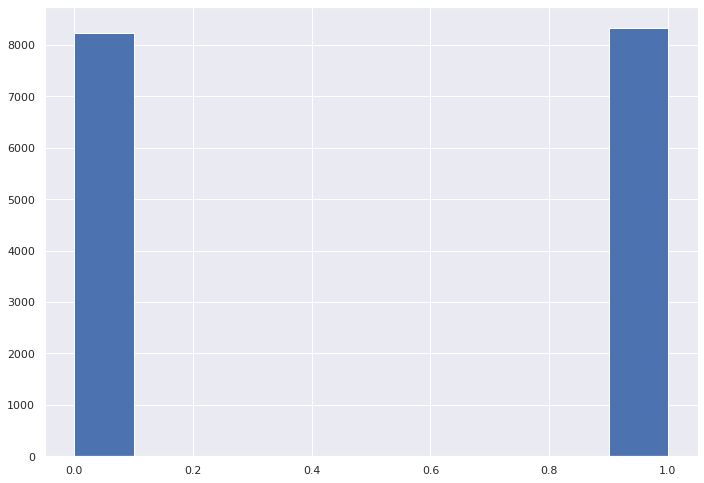

In [139]:
plt.hist(cl_pred)

(array([2788., 2861.,    0., 2610.,    0.,    0., 2718.,    0.,    0.,
           0.,    0.,    0.,    0., 2791.,    0.,    0.,    0.,    0.,
           0., 2792.]),
 array([ 1.  ,  2.45,  3.9 ,  5.35,  6.8 ,  8.25,  9.7 , 11.15, 12.6 ,
        14.05, 15.5 , 16.95, 18.4 , 19.85, 21.3 , 22.75, 24.2 , 25.65,
        27.1 , 28.55, 30.  ]),
 <BarContainer object of 20 artists>)

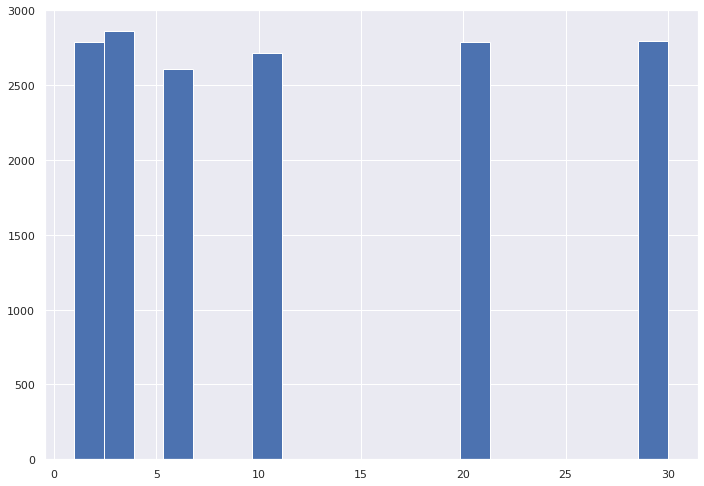

In [140]:
plt.hist(reg_pred, bins=20)

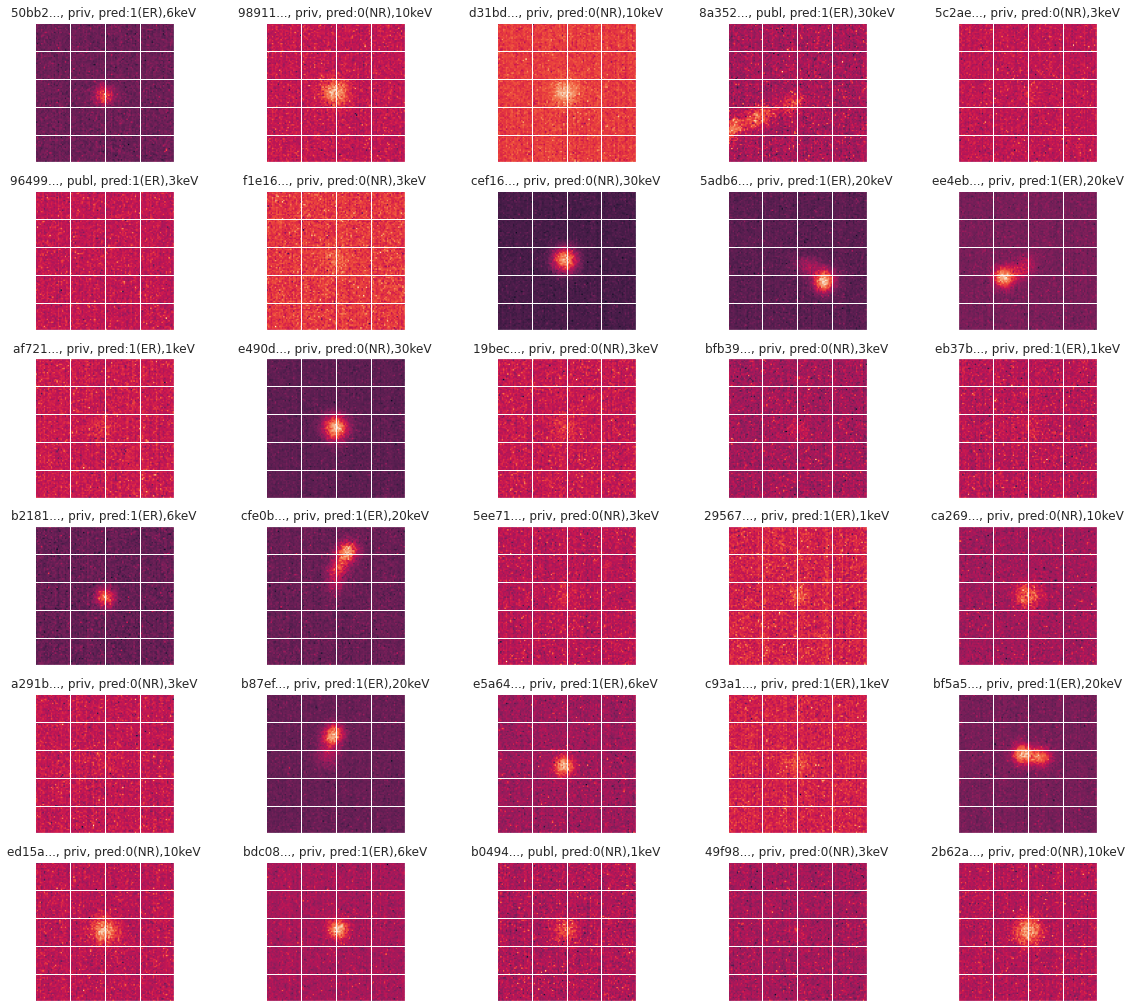

In [433]:
tmp = plot_images('../../idao_dataset/', im_filename='./pipeline_prediction.csv', max_num_images=30, rand_seed=10)

In [8]:
import pandas as pd
import numpy as np

# Drafts

In [9]:
df1 = pd.read_csv('pipeline_prediction_draft.csv')

In [10]:
df2 = pd.read_csv('pipeline_prediction.csv')

In [11]:
np.sum(df1 != df2)

id                            0
classification_predictions    0
regression_predictions        0
dtype: int64

#### submission

In [403]:
# cl_pred = np.append(np.round(LOW_cl_pred_public), np.round(LOW_cl_pred))
# reg_pred = np.append(LOW_reg_pred_public, LOW_reg_pred)
# im_names = np.append(LOW_im_names_public, LOW_im_names)
# #generate_submission(cl_pred, reg_pred, im_names, 'LOW_predictions')

In [404]:
# tmp = plot_images('../../idao_dataset/', im_filename='LOW_predictions.csv', max_num_images=30)

## Compare prediction on public with the solid solution

In [16]:
sol_s = pd.read_csv('solid_solution_for_public.csv')

In [268]:
cl_pred = np.append(np.round(LOW_cl_pred_public), np.round(MID_cl_pred_public))
cl_pred = np.append(cl_pred, np.round(HE_cl_pred_public))

reg_pred = np.append(np.round(LOW_reg_pred_public), np.round(MID_reg_pred_public))
reg_pred = np.append(reg_pred, np.round(HE_reg_pred_public))

im_names = np.append(LOW_im_names_public, MID_im_names_public)
im_names = np.append(im_names, HE_im_names_public)

In [269]:
generate_submission(cl_pred, reg_pred, im_names, 'pipeline_public')
pip_s = pd.read_csv('pipeline_public.csv')

In [107]:
pip_s.iloc[24]

id                            03f957407089261e5ecd4c7e9f961f5f91647fc3
classification_predictions                                           0
regression_predictions                                              20
Name: 24, dtype: object

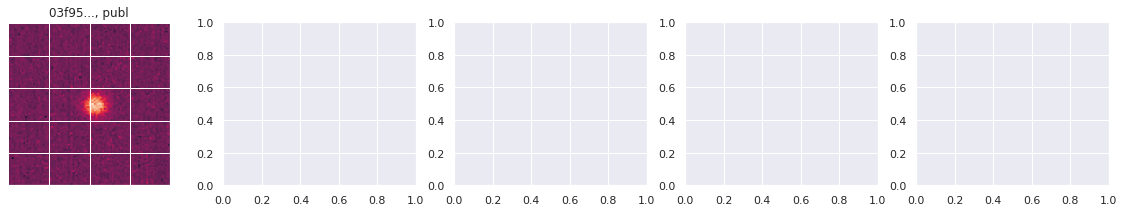

In [108]:
tmp = plot_images('../../idao_dataset/', im_filename=['03f957407089261e5ecd4c7e9f961f5f91647fc3'])

In [279]:
df_diff = sol_s != pip_s

In [281]:
df_diff_idx = [i for i in range(len(df_diff)) if df_diff['id'][i]==True or df_diff['classification_predictions'][i]==True or df_diff['regression_predictions'][i]==True]

In [284]:
# pip_s = pip_s.iloc[df_diff_idx].drop('id', axis=1)
df_d = sol_s.iloc[df_diff_idx].set_index('id').join(pip_s.iloc[df_diff_idx].set_index('id'), rsuffix='_pipeline')
df_d.regression_predictions = df_d.regression_predictions.astype(int)
df_d.classification_predictions_pipeline = df_d.classification_predictions_pipeline.astype(int)

In [285]:
def _color_red_or_green(val):
    color = 'black'
    if val == 30:
        color = 'red' 
    elif val == 20:
        color = 'green'
    elif val == 10:
        color = 'brown'
    elif val == 6:
        color = 'blue'
    elif val == 3:
        color = 'pink'
    
    return 'color: %s' % color

In [277]:
sol_s.head(5)

id  classification_predictions  \
0  001ec8f4d2679f2899a63e4b2597c0a10bd9393f                           0   
1  00327390bfd6101b87106e96e0efc1c938690e1f                           0   
2  00573dde8addbac780cfa35a55a790fa1aa45178                           0   
3  00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                           0   
4  00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2                           0   

   regression_predictions  
0                    20.0  
1                     6.0  
2                    20.0  
3                     6.0  
4                     6.0

In [278]:
pip_s.head(5)

id  classification_predictions  \
0  001ec8f4d2679f2899a63e4b2597c0a10bd9393f                         0.0   
1  00327390bfd6101b87106e96e0efc1c938690e1f                         0.0   
2  00573dde8addbac780cfa35a55a790fa1aa45178                         0.0   
3  00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                         1.0   
4  00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2                         0.0   

   regression_predictions  
0                      20  
1                       6  
2                      20  
3                       3  
4                       6

In [296]:
sum(np.abs(df_d['regression_predictions'].values - df_d['regression_predictions_pipeline'].values)) / 1502

1.6977363515312915

In [357]:
df_d.head()

classification_predictions  \
id                                                                     
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                           0   
0118f4bbc13bb2dfa2409f325e395919317d020a                           1   
02b855e6e1dfed8845b80885a898a27efe562b9c                           0   
03f957407089261e5ecd4c7e9f961f5f91647fc3                           1   
0434b00cfa6e902867cc467460a32ab071e99064                           1   

                                          regression_predictions  \
id                                                                 
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                       6   
0118f4bbc13bb2dfa2409f325e395919317d020a                      30   
02b855e6e1dfed8845b80885a898a27efe562b9c                       1   
03f957407089261e5ecd4c7e9f961f5f91647fc3                      10   
0434b00cfa6e902867cc467460a32ab071e99064                      30   

                                          classification_predictions_pipeline  \
id                                                                              
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                                    1   
0118f4bbc13bb2dfa2409f325e395919317d020a                                    1   
02b855e6e1dfed8845b80885a898a27efe562b9c                                    1   
03f957407089261e5ecd4c7e9f961f5f91647fc3                                    0   
0434b00cfa6e902867cc467460a32ab071e99064                                    1   

                                          regression_predictions_pipeline  
id                                                                         
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e                                3  
0118f4bbc13bb2dfa2409f325e395919317d020a                               10  
02b855e6e1dfed8845b80885a898a27efe562b9c                               10  
03f957407089261e5ecd4c7e9f961f5f91647fc3                               20  
0434b00cfa6e902867cc467460a32ab071e99064                                3

In [260]:
df.columns[:50]

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y', 'chi2_bkgr_only_x', 'chi2_bkgr_only_y',
       'chi2_pvalue_bkgr_only_x', 'chi2_pvalue_bkgr_only_y', 'chi2_pvalue_x',
       'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu', 'dsigma',
       'edm_bkgr_only_x', 'edm_bkgr_only_y', 'edm_x', 'edm_y', 'event_ID',
       'event_angle', 'event_class', 'event_energy', 'fr_error_x',
       'fr_error_y', 'fr_x', 'fr_y', 'fval_bkgr_only_x', 'fval_bkgr_only_y',
       'fval_x', 'fval_y', 'has_accurate_covar_bkgr_only_x',
       'has_accurate_covar_bkgr_only_y', 'has_accurate_covar_x',
       'has_accurate_covar_y', 'has_covariance_bkgr_only_x',
       'has_covariance_bkgr_only_y', 'has_covariance_x', 'has_covariance_y',
       'has_made_posdef_covar_bkgr_only_x',
       'has_made_posdef_covar_bkgr_only_y', 'has_made_posdef_covar_x',
       'has_made_posdef_covar_y', 'has_para

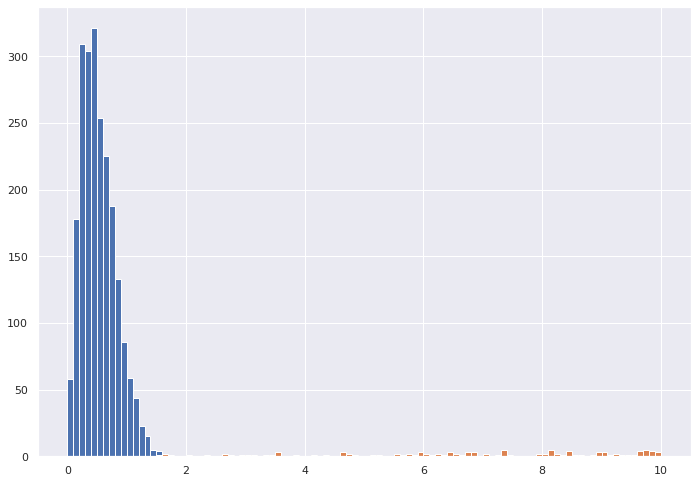

In [285]:
plt.hist(df.query('event_energy == 20 and event_class=="NR"')['abs_sum_dmu'], range=(0,10), bins=100)
h = plt.hist(df.query('event_energy == 30 and event_class=="ER"')['abs_sum_dmu'], range=(0,10), bins=100)

plt.show()

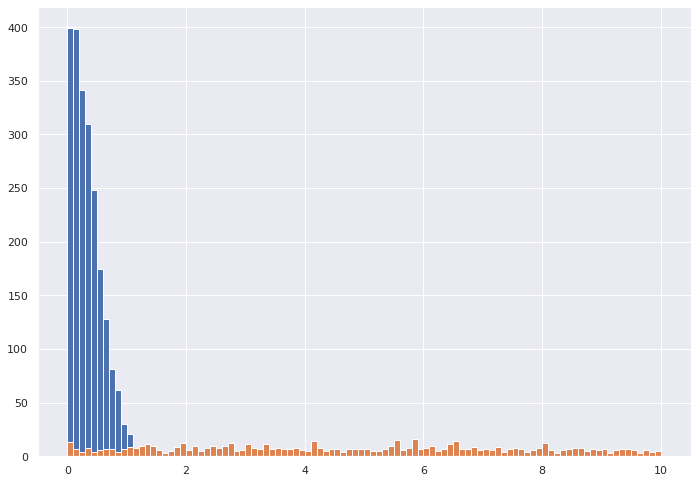

In [280]:
plt.hist(df.query('event_energy == 20 and event_class=="NR"')['abs_dmu_x'] + df.query('event_energy == 20 and event_class=="NR"')['abs_dmu_y'], range=(0,10), bins=100)
h = plt.hist(df.query('event_energy == 30 and event_class=="ER"')['abs_dmu_x'], range=(0,10), bins=100)

plt.show()

In [279]:
sum(h[0])

2237.0

(-5.0, 5.0)

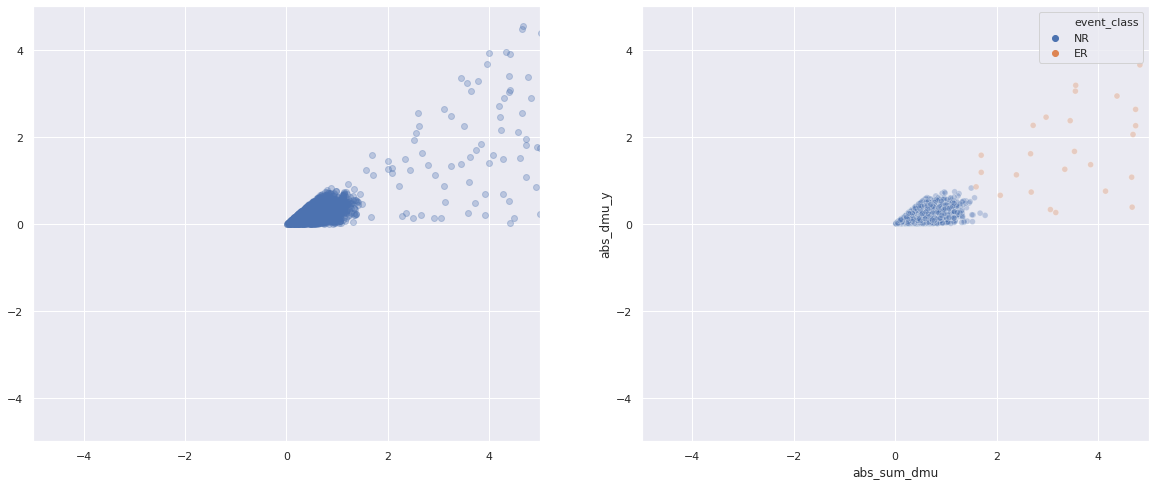

In [284]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_HE_private]['abs_sum_dmu'], df_private.iloc[idx_HE_private]['abs_dmu_y'], alpha=0.3)
axs[0].set_xlim([-5,5])
axs[0].set_ylim([-5,5])
sns.scatterplot(x='abs_sum_dmu', y='abs_dmu_y', data = df.query('event_energy == 20 or event_energy == 30'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,5])
plt.ylim([-5,5])

(-5.0, 5.0)

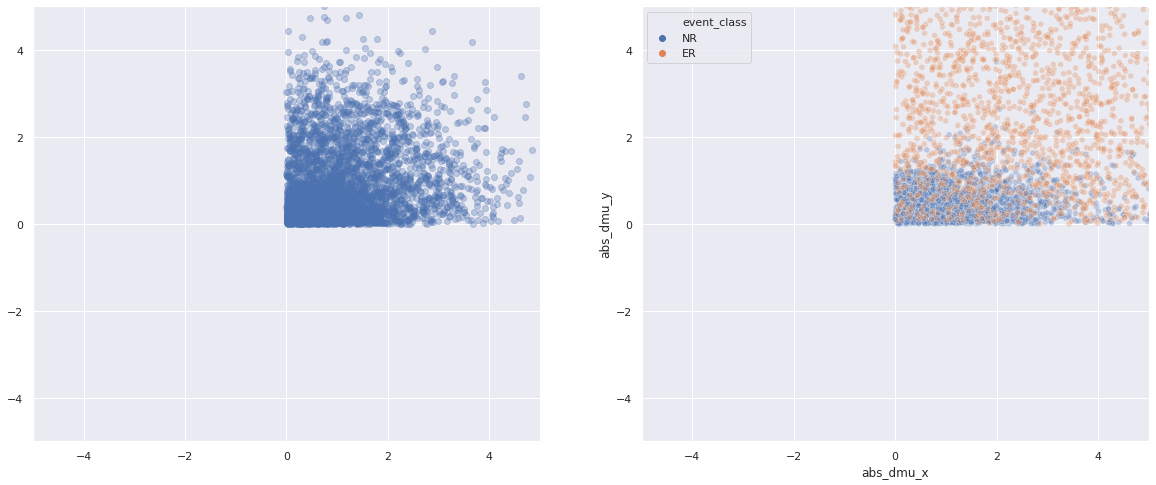

In [248]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_MID_private]['abs_dmu_x'], df_private.iloc[idx_MID_private]['abs_dmu_y'], alpha=0.3)
axs[0].set_xlim([-5,5])
axs[0].set_ylim([-5,5])
sns.scatterplot(x='abs_dmu_x', y='abs_dmu_y', data = df.query('event_energy == 6 or event_energy == 10'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,5])
plt.ylim([-5,5])

(-5.0, 5.0)

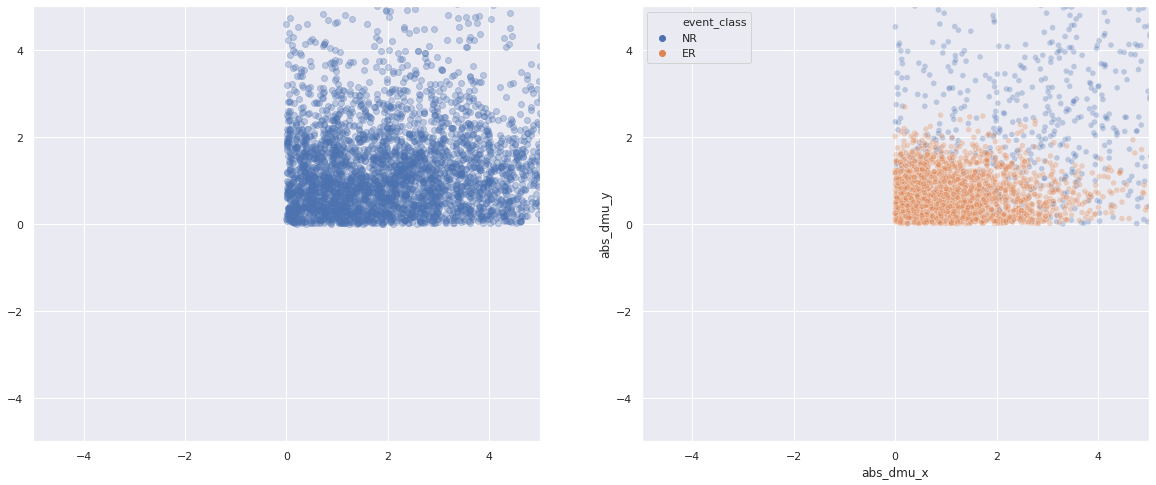

In [257]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_LOW_private]['abs_dmu_x'], df_private.iloc[idx_LOW_private]['abs_dmu_y'], alpha=0.3)
axs[0].set_xlim([-5,5])
axs[0].set_ylim([-5,5])
sns.scatterplot(x='abs_dmu_x', y='abs_dmu_y', data = df.query('event_energy == 1 or event_energy == 3'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,5])
plt.ylim([-5,5])

In [ ]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_HE_private]['abs_dmu_x'], df_private.iloc[idx_HE_private]['abs_dmu_y'], alpha=0.3)
axs[0].set_xlim([-5,5])
axs[0].set_ylim([-5,5])
sns.scatterplot(x='abs_dmu_x', y='abs_dmu_y', data = df.query('event_energy == 20 or event_energy == 30'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,5])
plt.ylim([-5,5])

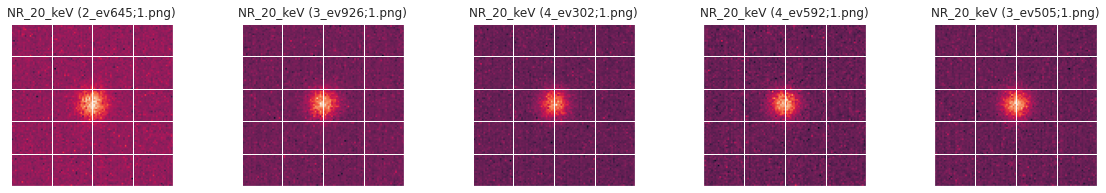

In [255]:
t = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=20, max_num_images=5)

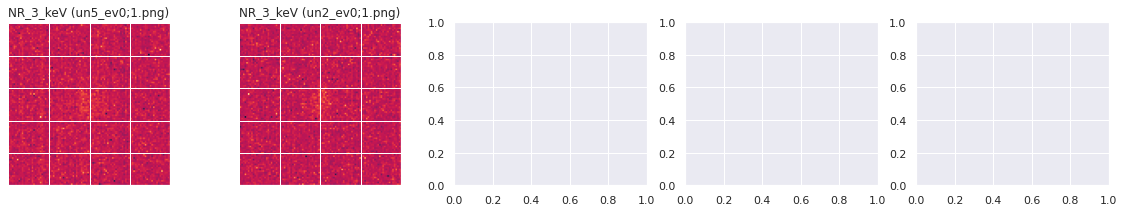

In [256]:
t = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=3, max_num_images=5)

(-5.0, 15.0)

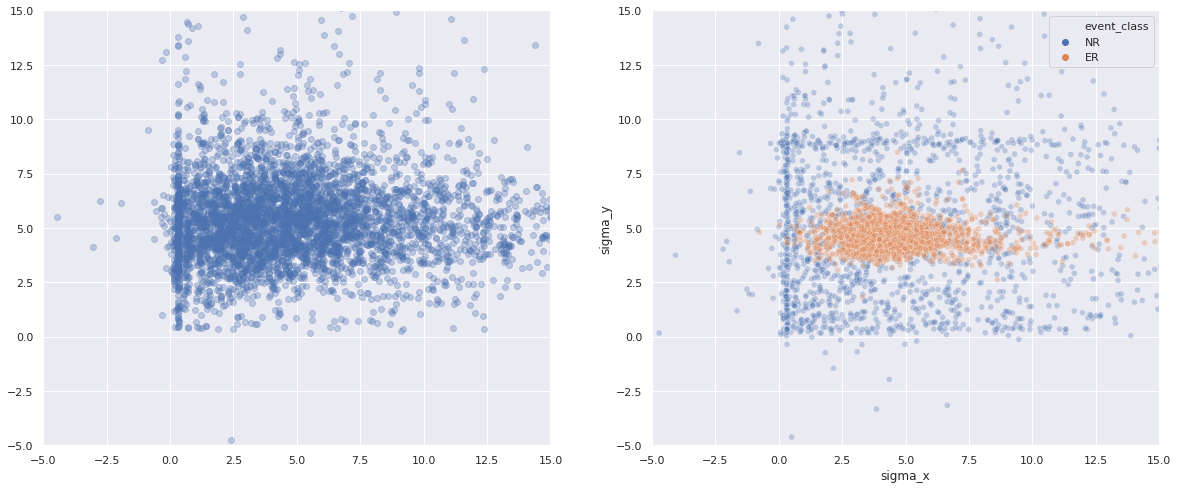

In [335]:
# train_HE_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_LOW_private]['sigma_x'], df_private.iloc[idx_LOW_private]['sigma_y'], alpha=0.3)
axs[0].set_xlim([-5,15])
axs[0].set_ylim([-5,15])
sns.scatterplot(x='sigma_x', y='sigma_y', data = df.query('event_energy == 1 or event_energy == 3'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,15])
plt.ylim([-5,15])

NameError: name 'idx_MID_private' is not defined

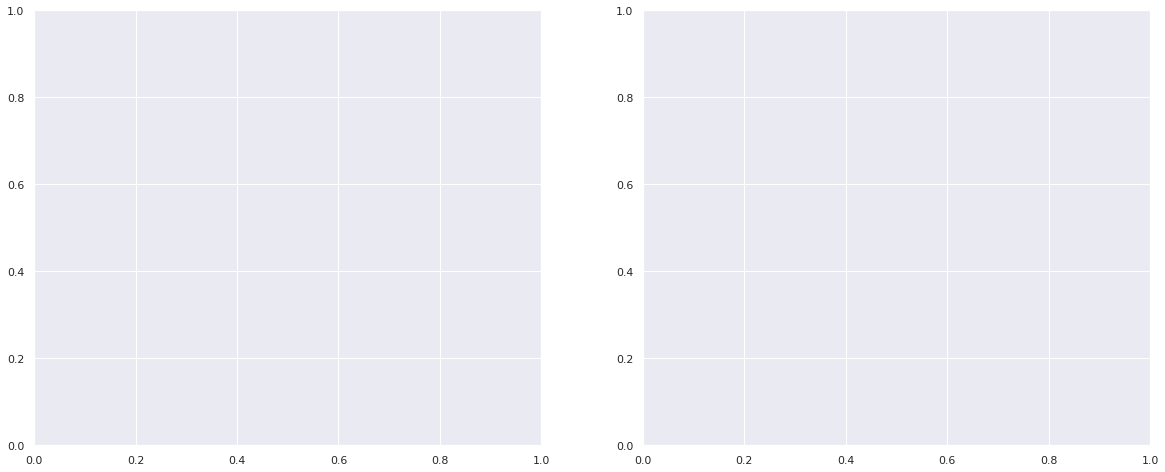

In [29]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_MID_private]['sigma_x'], df_private.iloc[idx_MID_private]['sigma_y'], alpha=0.3)
axs[0].set_xlim([0,10])
axs[0].set_ylim([3.5,7])
sns.scatterplot(x='sigma_x', y='sigma_y', data = df.query('event_energy == 6 or event_energy == 10'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([0,10])
plt.ylim([3.5,7])

(array([  0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   1.,   2.,   1.,   3.,   4.,   3.,  13.,  16.,  22.,  34.,
         38.,  50.,  52.,  70.,  80.,  68.,  85.,  86., 101., 108., 130.,
        106.,  98., 128., 107., 139., 124., 109.,  99.,  86.,  92.,  73.,
         81.,  74.,  69.,  75.,  68.,  62.,  53.,  50.,  65.,  53.,  68.,
         74.,  80.,  69.,  89.,  99.,  99.,  91.,  96.,  97., 102.,  99.,
        105.,  79., 106.,  90.,  90.,  63.,  63.,  63.,  68.,  54.,  35.,
         36.,  38.,  27.,  24.,  23.,  14.,  27.,   8.,  15.,   8.,   9.,
         10.,   5.,   5.,   9.,   7.,   5.,   5.,   5.,   2.,   1.,   3.,
          2.]),
 array([ 6.  ,  6.09,  6.18,  6.27,  6.36,  6.45,  6.54,  6.63,  6.72,
         6.81,  6.9 ,  6.99,  7.08,  7.17,  7.26,  7.35,  7.44,  7.53,
         7.62,  7.71,  7.8 ,  7.89,  7.98,  8.07,  8.16,  8.25,  8.34,
         8.43,  8.52,  8.61,  8.7 ,  8.79,  8.88,  8.97,  9.06,  9.15,
         9.24,  9.33,  9.42,  9.51

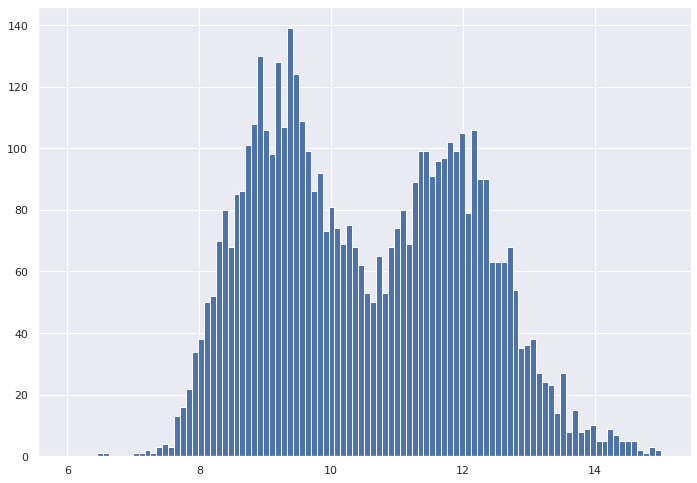

In [56]:
plt.hist(df_private.iloc[idx_MID_private]['sum_sgm'], range=(6,15), bins=100)

<AxesSubplot:xlabel='sum_sgm', ylabel='sigma_y'>

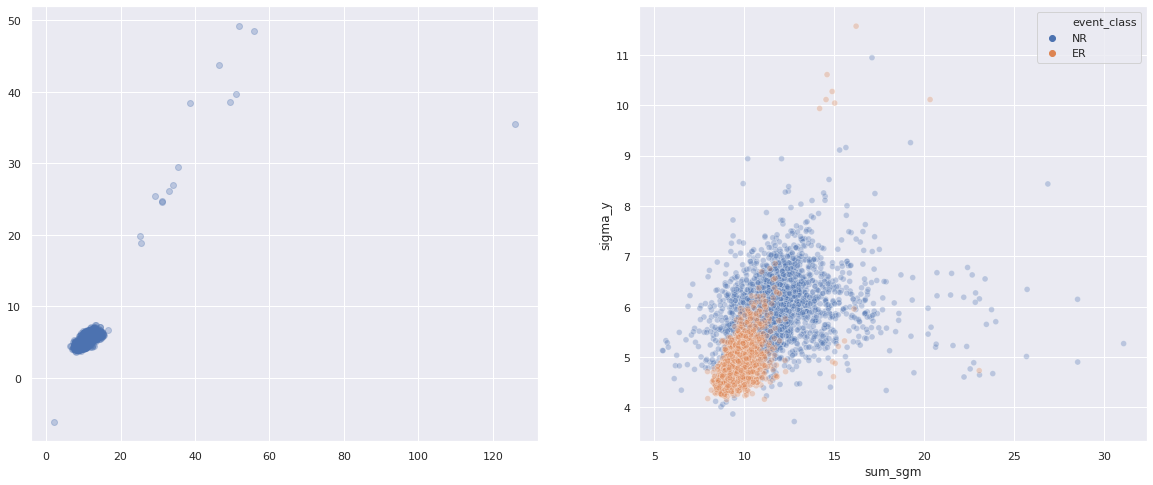

In [51]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_MID_private]['sum_sgm'], df_private.iloc[idx_MID_private]['sigma_y'], alpha=0.3)
#axs[0].set_xlim([0,10])
#axs[0].set_ylim([3.5,7])
sns.scatterplot(x='sum_sgm', y='sigma_y', data = df.query('event_energy == 6 or event_energy == 10'), hue = 'event_class', alpha=0.3, ax=axs[1])
#plt.xlim([0,10])
#plt.ylim([3.5,7])

(3.5, 7.0)

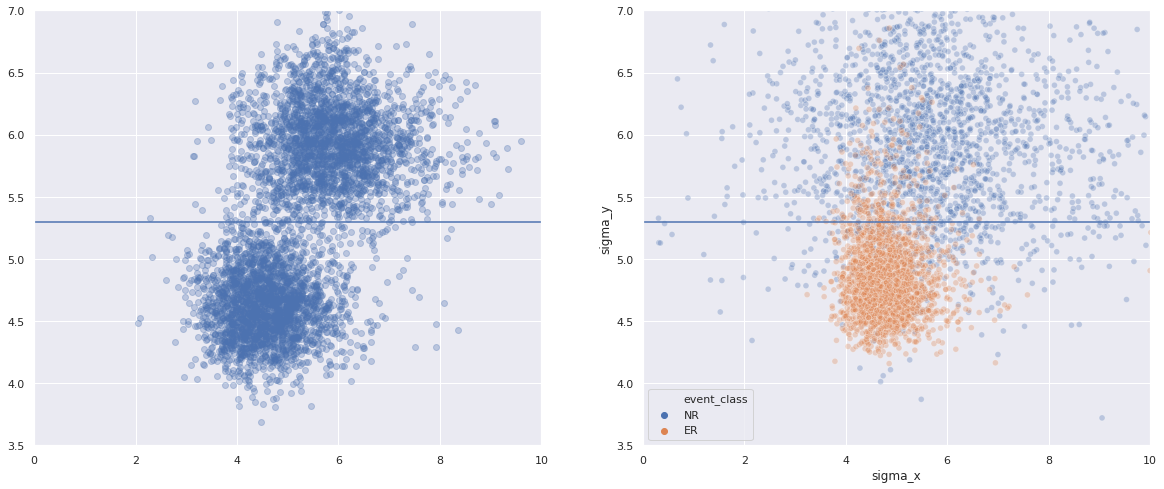

In [75]:
# train_MID_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 6) * ((df['sig_count_y'].values - b_NR)/a_NR < 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_MID_private]['sigma_x'], df_private.iloc[idx_MID_private]['sigma_y'], alpha=0.3)
axs[0].set_xlim([0,10])
axs[0].set_ylim([3.5,7])
axs[0].plot([0,10], [5.3, 5.3])
sns.scatterplot(x='sigma_x', y='sigma_y', data = df.query('event_energy == 6 or event_energy == 10'), hue = 'event_class', alpha=0.3, ax=axs[1])
axs[1].plot([0,10], [5.3, 5.3])
plt.xlim([0,10])
plt.ylim([3.5,7])

(-5.0, 15.0)

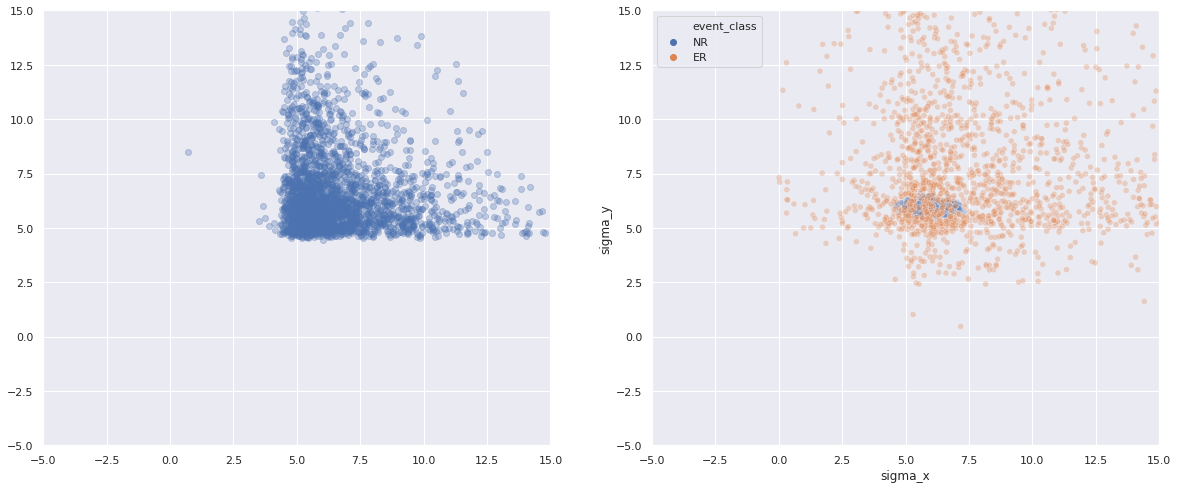

In [334]:
# train_HE_idx = np.ravel(np.argwhere(((df['sig_count_y'].values - b_NR)/a_NR > 14)))
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private.iloc[idx_HE_private]['sigma_x'], df_private.iloc[idx_HE_private]['sigma_y'], alpha=0.3)
axs[0].set_xlim([-5,15])
axs[0].set_ylim([-5,15])
sns.scatterplot(x='sigma_x', y='sigma_y', data = df.query('event_energy == 20 or event_energy == 30'), hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-5,15])
plt.ylim([-5,15])

(-10.0, 20.0)

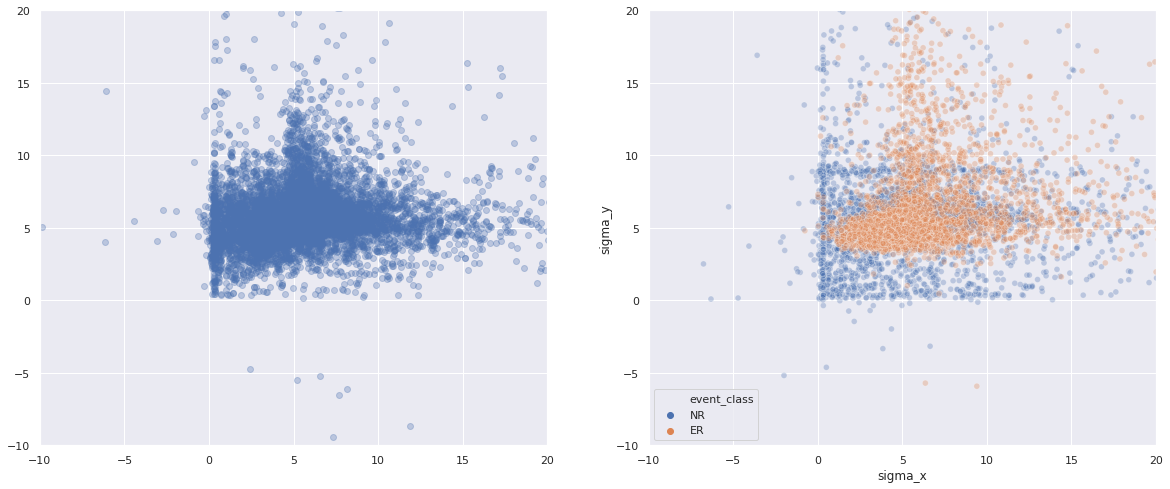

In [302]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].scatter(df_private['sigma_x'], df_private['sigma_y'], alpha=0.3)
axs[0].set_xlim([-10,20])
axs[0].set_ylim([-10,20])
sns.scatterplot(x='sigma_x', y='sigma_y', data = df, hue = 'event_class', alpha=0.3, ax=axs[1])
plt.xlim([-10,20])
plt.ylim([-10,20])

In [342]:
# df_private['sigma_y']

In [343]:
priv_MID_cl_pred = MID_clf.predict(df_private[MID_clf_vars])
# E_priv_MID = (df_private[priv_MID_cl_pred > 0.5].sig_count_y.values - b_NR)/a_NR
# E_priv_NR_MID = (df_private[priv_MID_cl_pred <= 0.5].sig_count_y.values - b_NR)/a_NR

E_priv_MID = (df_private.query('sigma_y <= 5.25 ').sig_count_y.values - b_NR)/a_NR
E_priv_NR_MID = (df_private.query('sigma_y > 5.25 ').sig_count_y.values - b_NR)/a_NR

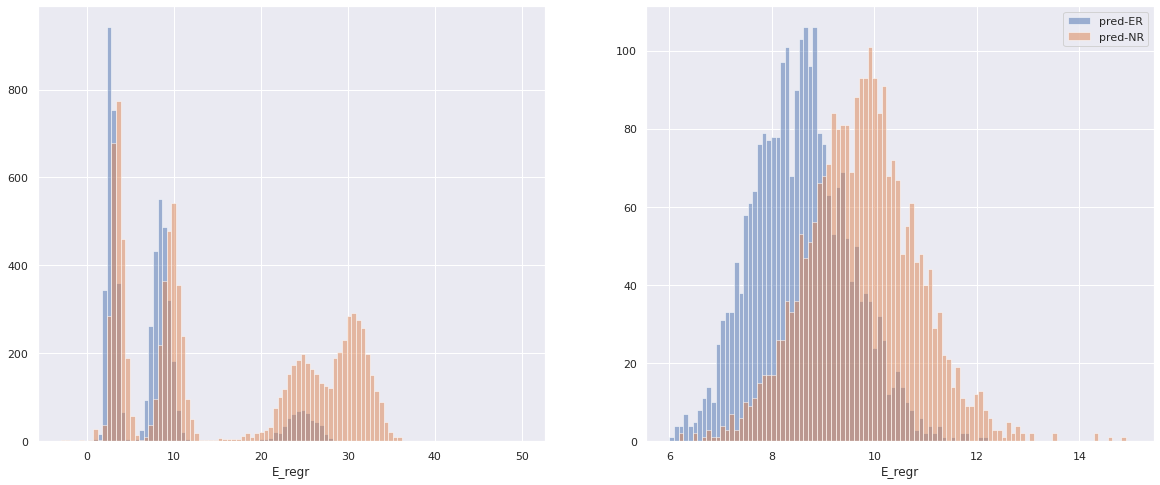

In [344]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_priv_MID, bins=100, range=(-3, 50), alpha=0.5, label='pred-ER')
axs[0].hist(E_priv_NR_MID, bins=100, range=(-3, 50), alpha=0.5, label='pred-NR')
axs[0].set_xlabel('E_regr')
axs[1].hist(E_priv_MID, bins=100, range=(6, 15), alpha=0.5, label='pred-ER')
axs[1].hist(E_priv_NR_MID, bins=100, range=(6, 15), alpha=0.5, label='pred-NR')
axs[1].set_xlabel('E_regr')
plt.legend()
# axs[1].axvline(26)
plt.show()